In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r'C:\Users\Mohamed Fawzi\Desktop\Warehouse Sales\Warehouse_and_Retail_Sales.csv')

df.head(2)

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.0,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.0,1.0,4.0


# Cleaning & Preparing The Data

In [21]:
# I will convert all columns name to be title case - I prefer it like that :)
df.columns = df.columns.str.title()

In [22]:
# drop null values
df.dropna(inplace=True)

In [23]:
df.isna().sum()

Year                0
Month               0
Supplier            0
Item Code           0
Item Description    0
Item Type           0
Retail Sales        0
Retail Transfers    0
Warehouse Sales     0
dtype: int64

In [24]:
# exclude 'STR_SUPPLIES', 'KEGS', 'REF', 'DUNNAGE', because most of the values are zeros
df = df[df['Item Type'].isin(['WINE', 'BEER', 'LIQUOR','NON-ALCOHOL'])]

In [25]:
df['Item Type'].unique()


array(['WINE', 'BEER', 'LIQUOR', 'NON-ALCOHOL'], dtype=object)

In [26]:
# Calculate mean values for only saleable items
saleable_items = ['WINE', 'BEER', 'LIQUOR', 'NON-ALCOHOL']  # Define saleable items
mean_values = df[df['Item Type'].isin(saleable_items)].groupby('Item Type')[['Warehouse Sales', 'Retail Transfers', 'Retail Sales']].mean()

# Define a function to replace zeros
def replace_zeros_with_mean(row, mean_values):
    item_type = row['Item Type']
    for col in ['Warehouse Sales', 'Retail Transfers', 'Retail Sales']:
        if row[col] == 0.0 and item_type in mean_values.index:
            row[col] = mean_values.loc[item_type, col]  # Replace zero with mean for this item type
    return row

# Apply the function to rows where the item type is saleable
df = df.apply(replace_zeros_with_mean, mean_values=mean_values, axis=1)

In [27]:
df.sample()

,Year,Month,Supplier,Item Code,Item Description,Item Type,Retail Sales,Retail Transfers,Warehouse Sales
65422,2017,8,ROYAL WINE CORP,306186,SENSEI SAKE - 750ML,WINE,3.978355,3.91504,2.0


In [28]:
# converting the Year & Month to datetime
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296862 entries, 0 to 307644
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Year              296862 non-null  int64         
 1   Month             296862 non-null  int64         
 2   Supplier          296862 non-null  object        
 3   Item Code         296862 non-null  object        
 4   Item Description  296862 non-null  object        
 5   Item Type         296862 non-null  object        
 6   Retail Sales      296862 non-null  float64       
 7   Retail Transfers  296862 non-null  float64       
 8   Warehouse Sales   296862 non-null  float64       
 9   Date              296862 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 24.9+ MB


In [29]:
# Convert numeric columns to float
numeric_columns = ['Retail Sales', 'Retail Transfers', 'Warehouse Sales']

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
#df.info()


In [30]:
# extract month name from the date column that I created earlier
df['Month Name'] = df['Date'].dt.month_name()

# Exploratory Data Analysis (EDA):

## **Item Type Analysis**

### Item Distribution

Now, let's see how many items fall under each item type to undersatand the distribution of item types in the dataset.

In [31]:
# item counts
df_items = df['Item Type'].value_counts().reset_index()
df_items

,Item Type,count
0,WINE,187640
1,LIQUOR,64910
2,BEER,42413
3,NON-ALCOHOL,1899


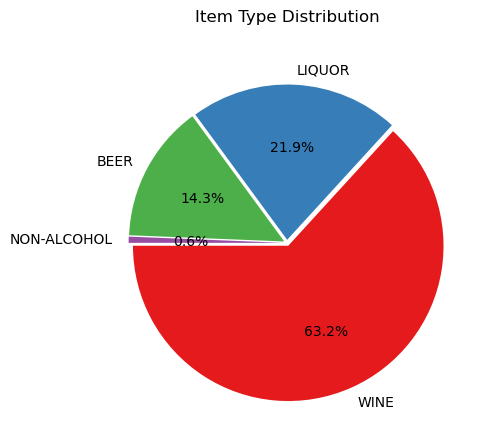

In [32]:
plt.figure(figsize=(5, 5))
plt.pie(
    df_items['count'],
    labels=df_items['Item Type'],
    autopct='%1.1f%%',
    startangle=180,
    colors=sns.color_palette('Set1'),
    explode=[0.02] * len(df_items)
)


plt.title('Item Type Distribution', pad=20)

sns.despine()
plt.tight_layout()
plt.show()

#### **Key Insights:**

1. **Wine Dominates the Product Mix**:

   * **Wine** represents the majority share at **63.2%**, indicating it’s the most stocked or sold item type—likely the primary revenue driver.

2. **Liquor and Beer Have Moderate Shares**:

   * **Liquor** accounts for **21.9%**, showing strong demand.
   * **Beer** holds **14.3%**, rounding out the major alcoholic categories.

3. **Non-Alcoholic Items Are Negligible**:

   * Just **0.6%** of the items fall under the **Non-Alcohol** category, suggesting very limited product variety or sales in this segment.


---


### Sale by Item Type

Let's see the total Warehouse and Retail Sales for each Item Type:


In [33]:
sales_by_item_type = df.groupby('Item Type')[['Warehouse Sales', 'Retail Sales']].sum().reset_index().round(2)
sales_by_item_type = sales_by_item_type.sort_values(by='Warehouse Sales', ascending=False)

sales_by_item_type_melted = sales_by_item_type.melt(id_vars='Item Type', var_name='Sales Type', value_name='Sales')
sales_by_item_type_melted

,Item Type,Sales Type,Sales
0,BEER,Warehouse Sales,6959533.38
1,WINE,Warehouse Sales,1408877.62
2,LIQUOR,Warehouse Sales,170856.14
3,NON-ALCOHOL,Warehouse Sales,36491.00
4,BEER,Retail Sales,880846.95
5,WINE,Retail Sales,1089747.11
6,LIQUOR,Retail Sales,828450.27
7,NON-ALCOHOL,Retail Sales,30681.71


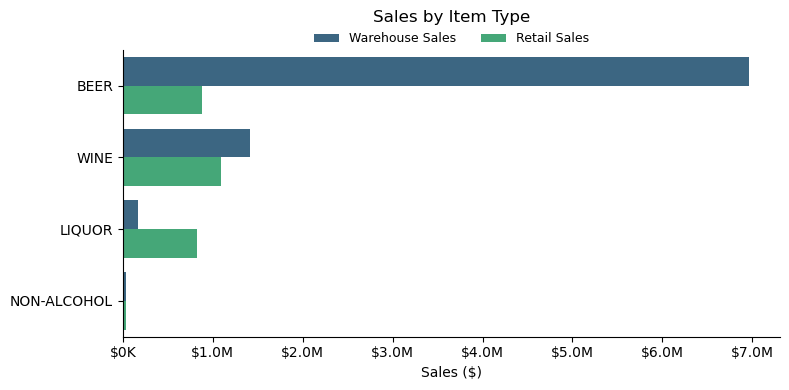

In [34]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=sales_by_item_type_melted,
    x='Sales',
    y='Item Type',
    hue='Sales Type',
    palette='viridis'
)


def format_currency(x, pos):
    if x >= 1e6:
        return '${:1.1f}M'.format(x*1e-6)
    else:
        return '${:1.0f}K'.format(x*1e-3)


plt.gca().xaxis.set_major_formatter(FuncFormatter(format_currency)) 

plt.title('Sales by Item Type', pad=20)
plt.xlabel('Sales ($)')
plt.ylabel('')

plt.legend(ncols=2, loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.1), fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()

#### **Key Insights:**

1. **Beer Drives Warehouse Sales**:

   * **Beer** dominates warehouse sales with nearly **\$7M**, far exceeding all other categories.
   * Indicates a strong B2B demand, possibly from bars, restaurants, or distributors.

2. **Retail Sales Are More Balanced**:

   * **Wine** and **Liquor** perform relatively well in retail, each generating over **\$1M**.
   * Suggests wine and liquor are more popular among direct consumers.

3. **Wine: Stocked Most, But Lower Warehouse Sales**:

   * Despite being **63% of the item mix** (as seen in the pie chart), **wine** contributes modestly to warehouse sales.
   * This imbalance may point to lower B2B demand or higher inventory holding.

4. **Liquor Reverses the Trend**:

   * Although **liquor** was only **21.9%** of the item mix, its **retail sales surpass warehouse sales**, hinting at strong consumer appeal.

5. **Non-Alcoholic Items Are Negligible Across Channels**:

   * Both warehouse and retail sales are minimal, reinforcing the earlier insight that this segment is underrepresented.

---


### Top 10 Revenue-Generating Items

In [35]:
df['Total_Sales'] = df['Retail Sales'] + df['Warehouse Sales']
top_items = df.groupby('Item Description')['Total_Sales'].sum().nlargest(10).reset_index().round(2)
top_items

,Item Description,Total_Sales
0,CORONA EXTRA LOOSE NR - 12OZ,328224.83
1,CORONA EXTRA 2/12 NR - 12OZ,257679.62
2,HEINEKEN LOOSE NR - 12OZ,189711.21
3,HEINEKEN 2/12 NR - 12OZ,162224.15
4,MILLER LITE 30PK CAN - 12OZ,148926.40
5,CORONA EXTRA 4/6 NR - 12OZ,132679.15
6,MODELO ESPECIAL 24 LOOSE NR - 12OZ,121846.80
7,BUD LIGHT 30PK CAN,108615.97
8,HEINEKEN 4/6 NR - 12OZ,105279.69
9,CORONA EXTRA 18PK NR - 12OZ,100786.29


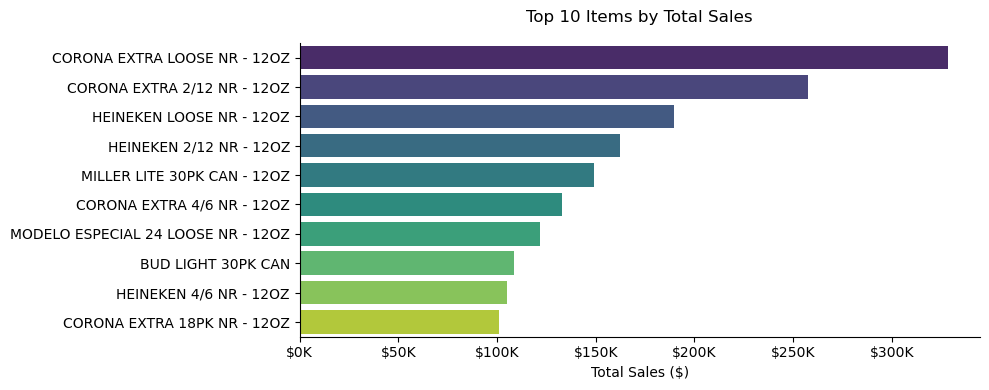

In [36]:
plt.figure(figsize=(10, 4))
sns.barplot(
    data=top_items,
    x='Total_Sales',
    y='Item Description',
    palette='viridis'
)


plt.gca().xaxis.set_major_formatter(FuncFormatter(format_currency)) # the function is defined earlier in the code.

plt.title('Top 10 Items by Total Sales', pad=15)
plt.xlabel('Total Sales ($)')
plt.ylabel('')


sns.despine()
plt.tight_layout()
plt.show()

#### **Key Insights:**

This bar chart shows the **Top 10 Items by Total Sales**, highlighting which products generate the most revenue. Here are the key observations:

---

#### **1. CORONA EXTRA LOOSE NR - 12OZ Dominates Sales**
- **Total Sales**: Approximately **$320,000**.
- **Insight**: This product is the clear leader in total sales, indicating:
  - High demand among consumers.
  - Effective pricing and marketing strategies.
  - Strong brand recognition or loyalty.

#### **2. CORONA EXTRA 2/12 NR - 12OZ Follows Closely**
- **Total Sales**: Around **$250,000**.
- **Insight**: This variant of Corona also performs exceptionally well, suggesting:
  - Consistent consumer preference for Corona products.
  - Different packaging options (e.g., loose vs. 2-pack) cater to diverse customer needs.

#### **3. HEINEKEN Products Show Strong Performance**
- **HEINEKEN LOOSE NR - 12OZ**: Total sales around **$190,000**.
- **HEINEKEN 2/12 NR - 12OZ**: Total sales around **$160,000**.
- **Insight**: Heineken products rank highly, indicating:
  - Strong brand appeal and market penetration.
  - Similar packaging strategies (loose and 2-pack) driving consistent sales.

#### **4. MILLER LITE 30PK CAN - 12OZ Performs Well**
- **Total Sales**: Around **$150,000**.
- **Insight**: This large-pack option (30-pack can) suggests:
  - Bulk purchasing behavior among customers.
  - Competitive pricing or promotions for this format.

#### **5. Other Top Sellers Show Moderate Performance**
- **CORONA EXTRA 4/6 NR - 12OZ**: Total sales around **$130,000**.
- **MODELO ESPECIAL 24 LOOSE NR - 12OZ**: Total sales around **$120,000**.
- **BUD LIGHT 30PK CAN**: Total sales around **$110,000**.
- **MODELO ESPECIAL-2/12 CAN - 12OZ**: Total sales around **$90,000**.
- **COORS LT 30PK CAN - 12OZ**: Total sales around **$80,000**.
- **Insight**: These products demonstrate steady performance, indicating:
  - Established brands with consistent demand.
  - Packaging formats (e.g., 24-loose, 2-pack, 30-pack) catering to different customer preferences.

#### **6. Pack Size Matters**
- **Large-Packs (30PK)**:  
  - **MILLER LITE 30PK CAN - 12OZ**, **BUD LIGHT 30PK CAN**, and **COORS LT 30PK CAN - 12OZ** show strong sales, suggesting bulk purchasing trends.
- **Smaller Packs (2/12, Loose)**:  
  - **CORONA EXTRA 2/12 NR - 12OZ**, **HEINEKEN 2/12 NR - 12OZ**, and **HEINEKEN LOOSE NR - 12OZ** indicate that smaller, more convenient packs also drive significant sales.

---